# Integrating the value function correctly

Right now I'm using the generic `scipy.integrate.quad`, which is probably slow (tons of integration points)
and not precise.

It seems it also struggles with some values of lambdas and p.

Objectives:

1. Write a Gauss-Hermite integration procedure
2. Check for accuracy against `scipy.integrate.quad`
3. Check for lambdas, p points where the integration struggles


The integration is over future states of log demand.

$$ \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) b_t(x_{t+1}| a_t, I_t )\; d x_{t+1} = \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) \left[\sum_{l=1}^L p_l(x_{t+1}) \lambda_l\right] \; d x_{t+1} $$

$$ = \sum_{l=1}^L \left[ \int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) p_l(x_{t+1}) ; d x_{t+1} \right] * \lambda_l $$

Since $p_l(x_{t+1})$ is a normal pdf, it makes sense to use Gauss-Hermite integration for each element of the sum above (See Judd(1998) "Numerical Methods in Economics", page 261ff):

$$\int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) p_l(x_{t+1}) ; d x_{t+1} \approx \pi^{-1/2} \sum_{i=1}^n w_i V(\sqrt{2} \sigma x_i + \mu_l)$$

where $x_i, w_i$ are Gauss-Hermite collocation points and weights and

$$ \mu_l = \alpha + \beta_l \log p_t $$

According to Judd (1998), ~7 nodes might be enough to get a low error.

The sample points and weights are obtained from https://keisan.casio.com/exec/system/1281195844


In [7]:
import sys
sys.path.append("../")
sys.path.append("../examples")
import src
import src.constants as const
import scipy.integrate as integrate
from aguirregabiria_simple import v0
import numpy as np
from typing import Callable
import dill


lambdas = src.generate_simplex_3dims(10)
rand_n = np.random.randint(0, high=len(lambdas))

r_lambda_point = lambdas[rand_n]
print(r_lambda_point)

[0.55555556 0.11111111 0.33333333]


In [8]:
v0(r_lambda_point[:-1])

1.8319599531181427

In [10]:
i = 1
length_of_price_grid = 10
min_price, max_price = 0.5, 1.5
dmd_transition_fs = src.dmd_transition_fs
update_lambdas = src.update_lambdas
belief = src.belief
wGuess = v0
p_array = np.linspace(min_price, max_price, num=length_of_price_grid) 


for i in range(len(p_array)):
    def new_lambdas(new_dmd):
        return update_lambdas(new_dmd, transition_fs=dmd_transition_fs,
                              old_lambdas=r_lambda_point, action=p_array[i], old_state=2.5)
    
    def new_belief(new_dmd):
        """
        Don't update lambdas! Use the ones from the current period
        """
        return belief(new_dmd, transition_fs=dmd_transition_fs,
                      lambda_weights=r_lambda_point,
                      action=p_array[i], old_state=2.5)

    def integrand(new_dmd):
        return wGuess(new_lambdas(new_dmd)[:-1]) * new_belief(new_dmd)

    logd_min, logd_max = -6, 5#-6, 2.3
    integrated_values, error = integrate.quad(integrand, logd_min, logd_max)
    print(p_array[i], integrated_values)

0.5 2.2244667159948195
0.6111111111111112 2.149883081425745
0.7222222222222222 2.022979403003241
0.8333333333333333 1.9000566475895362
0.9444444444444444 1.8380645437067031
1.0555555555555556 1.837405161942844
1.1666666666666665 1.8803956163455204
1.2777777777777777 1.9515453287984472
1.3888888888888888 2.0256870895462193
1.5 2.0896614791476216


## Trapezoid rule

In [16]:
from scipy import integrate
length_of_price_grid = 10
min_price, max_price = 0.5, 1.5
dmd_transition_fs = src.dmd_transition_fs
update_lambdas = src.update_lambdas
belief = src.belief
wGuess = v0
p_array = np.linspace(min_price, max_price, num=length_of_price_grid) 


integration_results = np.empty_like(p_array)
for i, price in enumerate(p_array):
    def new_lambdas(new_dmd):
        return update_lambdas(new_dmd, transition_fs=dmd_transition_fs,
                              old_lambdas=r_lambda_point, action=price, old_state=2.5)
    
    def new_belief(new_dmd):
        """
        Don't update lambdas! Use the ones from the current period
        """
        return belief(new_dmd, transition_fs=dmd_transition_fs,
                      lambda_weights=r_lambda_point,
                      action=price, old_state=2.5)

    def integrand(new_dmd):
        return wGuess(new_lambdas(new_dmd)[:-1]) * new_belief(new_dmd)
    yvals = []
    xvals = np.linspace(-6, 5, num=20)
    for x in xvals:
        yvals.append(integrand(x))
    integration_results[i] =  integrate.trapz(yvals, xvals)

integration_results

array([2.21217142, 2.14426556, 2.02159351, 1.90007948, 1.83806341,
       1.83740514, 1.88038261, 1.95193488, 2.02402058, 2.09196357])

In [28]:
hermite_xs = np.array([-2.6519613568352334924470820065166161144,
-1.6735516287674714450318013983035948191,
             -0.81628788285896466303871095902714581674, 0., 0.8162878828589646630387109590271458167,
1.6735516287674714450318013983035948191, 2.6519613568352334924470820065166161144])

hermite_ws = np.array([9.717812450995191541494242559389596444E-4,
0.054515582819127030592178568841695125961,
0.42560725261012780052031746666639103544,
0.8102646175568073267648765638130949407,
0.42560725261012780052031746666639103544,
0.054515582819127030592178568841695125961,
9.717812450995191541494242559389596444E-4])


## New Belief check

New belief should be a gaussian mixture density.

Does it behave that way?

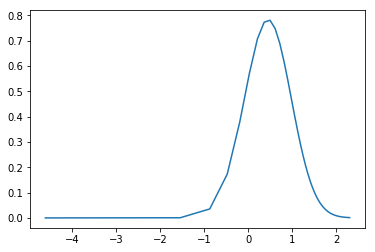

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt


def new_belief(new_dmd):
    return belief(new_dmd, transition_fs=dmd_transition_fs,
                  lambda_weights=new_lambdas(new_dmd),
                  action=p_array[i], old_state=2.5)

new_beliefs_vals = []
#rescaled_demands = rescale_demand(hermite_point, beta_l, p_array)
rescaled_demands = np.log(np.linspace(0.01, 10, 50))
for dmd in rescaled_demands:
    new_beliefs_vals.append(new_belief(dmd))

fig, ax = plt.subplots(1, 1)
ax.plot(rescaled_demands, new_beliefs_vals)

1.5


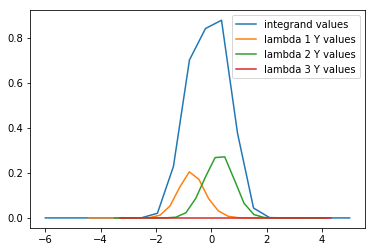

In [75]:
fig, ax = plt.subplots(1, 1)
ax.plot(xvals, np.array(yvals), label='integrand values')

#p1.5
print(p_array[i])
xy_val_d = gauss_hermite_y_values(v0, p_array[i], r_lambda_point, hermite_xs, hermite_ws)

xs = xy_val_d[0][:, 0]
ys = xy_val_d[0][:, 1]
ax.plot(xs, np.pi**(-0.5)*ys, label='lambda 1 Y values')

xs = xy_val_d[1][:, 0]
ys = xy_val_d[1][:, 1]
ax.plot(xs, np.pi**(-0.5)*ys, label='lambda 2 Y values')

xs = xy_val_d[2][:, 0]
ys = xy_val_d[2][:, 1]
ax.plot(xs, np.pi**(-0.5)*ys, label='lambda 3 Y values')

ax.legend()

In [73]:
hermite_point = hermite_xs[4]
beta_l = const.betas_transition[0]
rescaled_demand = rescale_demand(hermite_point, beta_l, p_array) 
for hpoint in hermite_xs:
    print(hpoint, rescale_demand(hpoint, beta_l=0.3, price=p_array[0]))

In [134]:
const.σ_ɛ 

0.5

## Gauss-Hermite

In [19]:
import quadpy
sqrt2 = np.sqrt(2)

def rescale_demand(dmd, beta_l, price):
    """
    Rescales demand to use Gauss-Hermite collocation points
    """
    mu = const.α + beta_l*np.log(price)
    return sqrt2*const.σ_ɛ * dmd + mu


rule = quadpy.e1r2.GaussHermite(7)
hermite_xs = rule.points
hermite_ws = rule.weights


def gauss_hermite_integrate(f, price, lambdas, hermite_xs, hermite_ws):
    """
    Integrates f with Guass-Hermite
    """
    def new_lambdas(new_dmd):
        return update_lambdas(new_dmd, transition_fs=dmd_transition_fs,
                              old_lambdas=lambdas, action=price, old_state=2.5)
    
    sum_over_each_lambda = 0.
    for l, beta_l in enumerate(const.betas_transition):
        for k, hermite_point in enumerate(hermite_xs):
            rescaled_demand = rescale_demand(hermite_point, beta_l, price)
            new_lambdas_value = new_lambdas(rescaled_demand)
            v_value = f(new_lambdas_value[:-1])
            sum_over_each_lambda += v_value*hermite_ws[k]*lambdas[l]
    
    return np.pi**(-0.5)*sum_over_each_lambda

def gauss_hermite_y_values(f, price, lambdas, hermite_xs, hermite_ws):
    """
    Generate one y value per lambda (one y value per integral)
    """
    xy_val_d = {0 : np.empty((len(hermite_xs), 2)),
               1: np.empty((len(hermite_xs), 2)),
               2: np.empty((len(hermite_xs), 2))}
    for k, hermite_point in enumerate(hermite_xs):
        for l, beta_l in enumerate(const.betas_transition):
            rescaled_demand = rescale_demand(hermite_point, beta_l, price)
            new_lambdas_value = new_lambdas(rescaled_demand)
            v_value = f(new_lambdas_value[:-1])
            xy_val_d[l][k] = np.array([rescaled_demand, v_value*lambdas[l]*hermite_ws[k]])
    
    return xy_val_d

for p in p_array:
    value = gauss_hermite_integrate(v0, p, r_lambda_point, hermite_xs, hermite_ws)
    print(value)

2.239846837690709
2.1500530271902845
2.0211934251294577
1.9000576442381925
1.8380645436485563
1.8374051619124305
1.8804014868774093
1.9509661692392688
2.0239362231016425
2.090436760813255


In [ ]:
0.5 2.097631964103887
0.6111111111111112 2.0258762057654995
0.7222222222222222 1.9053169548058806
0.8333333333333333 1.779015534017279
0.9444444444444444 1.7013122107746927
1.0555555555555556 1.700316111841822
1.1666666666666665 1.7564714370809296
1.2777777777777777 1.8340364838929195
1.3888888888888888 1.9079493525942577
1.5 1.9692222766302676


In [62]:
hermite_point = hermite_xs[4]
beta_l = const.betas_transition[0]
np.e**rescale_demand(hermite_point, beta_l, p_array) 

array([38.73115206, 21.21338081, 12.85162032,  8.36592885,  5.74699977,
        4.11649072,  3.04880789,  2.32062216,  1.80704063,  1.43448711])

$$\int V_{b_{t+1}}(I_{t+1}(x_{t+1}, I_t)) p_l(x_{t+1}) ; d x_{t+1} \approx \pi^{-1/2} \sum_{i=1}^n w_i V(\sqrt{2} \sigma x_i + \mu_l)$$

In [29]:
rescale_demand(hermite_xs, -3, price=1.4)

array([-1.88463657, -1.19279642, -0.58661941, -0.00941671,  0.56778599,
        1.173963  ,  1.86580315])

In [23]:
const.betas_transition

array([-3. , -2.5, -2. ])

## Using QuadPy

In [ ]:
quadpy.e1r2.integrate(
    lambda x: x**2,
    quadpy.e1r2.GaussHermite(5)
    )

In [99]:
import quadpy
val = quadpy.e1r2.integrate(
    lambda x: x**2,
    quadpy.e1r2.GaussHermite(5)
    )
val

0.8862269254527577

In [103]:
new_hermite_xs = np.array([-2.0201828704561, -0.95857246461382, 0, 0.95857246461382, 2.0201828704561])
new_hermite_ws = np.array([0.019953242059046, 0.39361932315224, 0.94530872048294,
                           0.39361932315224, 0.019953242059046])


def simple_gauss_hermite(f, new_hermite_xs, new_hermite_ws):
    return np.pi**(0.5)*np.pi**(-0.5)*np.dot(f(hermite_xs), hermite_ws)

def example_f(x):
    return x**2

simple_gauss_hermite(example_f, hermite_xs, hermite_ws)


0.886226925452758

In [100]:
hermite_xs

array([-5.38748089, -4.60368245, -3.94476404, -3.34785457, -2.78880606,
       -2.254974  , -1.73853771, -1.23407622, -0.73747373, -0.24534071,
        0.24534071,  0.73747373,  1.23407622,  1.73853771,  2.254974  ,
        2.78880606,  3.34785457,  3.94476404,  4.60368245,  5.38748089])

In [101]:
hermite_ws

array([2.22939365e-13, 4.39934099e-10, 1.08606937e-07, 7.80255648e-06,
       2.28338636e-04, 3.24377334e-03, 2.48105209e-02, 1.09017206e-01,
       2.86675505e-01, 4.62243670e-01, 4.62243670e-01, 2.86675505e-01,
       1.09017206e-01, 2.48105209e-02, 3.24377334e-03, 2.28338636e-04,
       7.80255648e-06, 1.08606937e-07, 4.39934099e-10, 2.22939365e-13])

In [87]:
rule = quadpy.e1r2.GaussHermite(5)

In [85]:
avers.weights

array([0.01995324, 0.39361932, 0.94530872, 0.39361932, 0.01995324])

In [86]:
avers.points

array([-2.02018287, -0.95857246,  0.        ,  0.95857246,  2.02018287])

In [92]:
np.dot(example_f(rule.points.T), rule.weights)

0.8862269254527577

In [89]:
rule.points.T

array([-2.02018287, -0.95857246,  0.        ,  0.95857246,  2.02018287])

In [90]:
rule.points

array([-2.02018287, -0.95857246,  0.        ,  0.95857246,  2.02018287])